In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install netron

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00


In [ ]:
! pip install torchvision

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [5]:
data_dir = '/content/drive/MyDrive/deep_learning_project/face_expression_dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'test']
Train Classes - ['neutral', 'surprise', 'sad', 'disgust', 'fear', 'angry', 'happy']
Validation Classes - ['sad', 'surprise', 'neutral', 'disgust', 'happy', 'fear', 'angry']


In [40]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [6]:
sample_img=cv2.imread("/content/drive/MyDrive/deep_learning_project/face_expression_dataset/train/angry/Training_2944904.jpg")

In [7]:
sample_img.shape

(48, 48, 3)

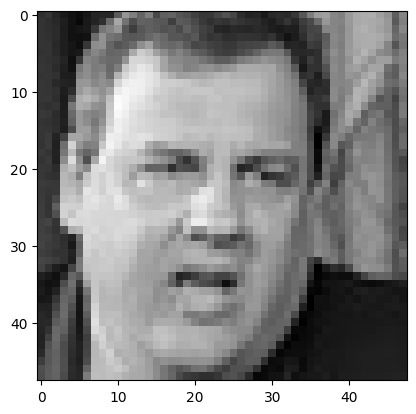

In [8]:
plt.imshow(sample_img)

In [9]:
# Data augmentation and loading
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [10]:
batch_size = 200
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([1, 48, 48])


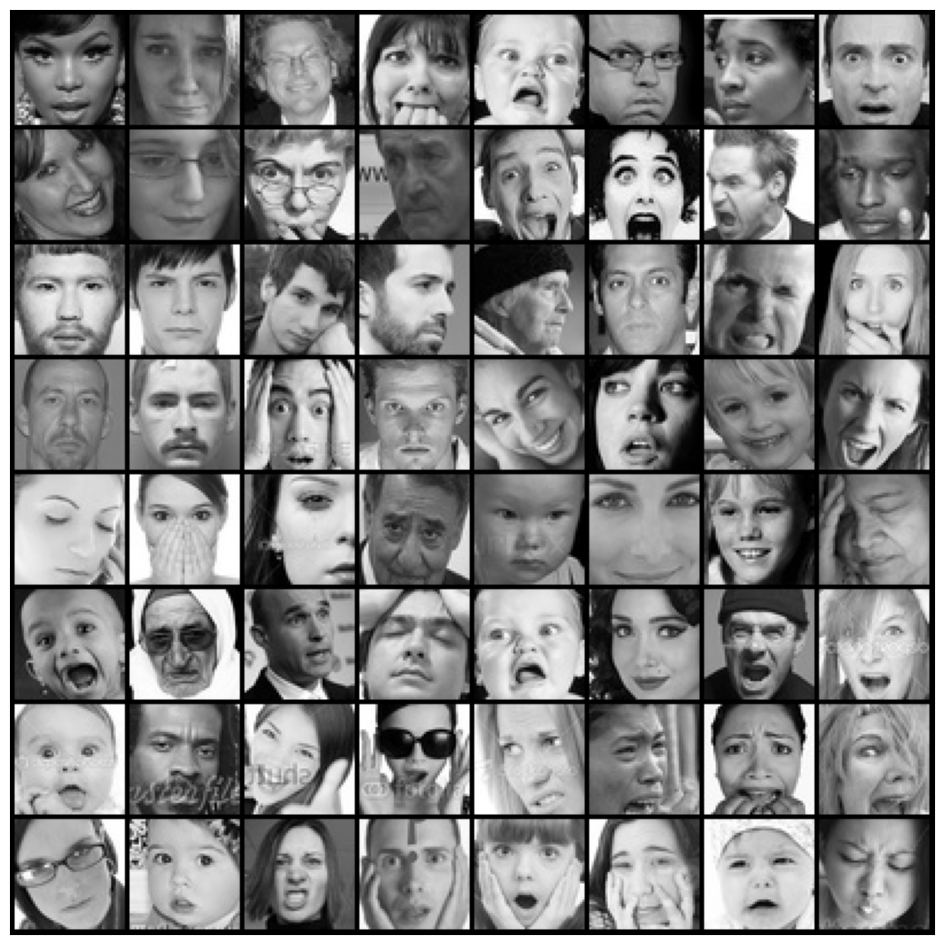

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_dl)

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)

        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))

    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        return self.classifier(out)

In [17]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.948564887046814, 'val_acc': 0.15333333611488342}]

In [ ]:
epochs = 30
max_lr = 0.001
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.RMSprop

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 2.3435, val_loss: 1.9487, val_acc: 0.1658
Epoch [1], last_lr: 0.00015, train_loss: 1.9632, val_loss: 1.9318, val_acc: 0.2121
Epoch [2], last_lr: 0.00028, train_loss: 1.9072, val_loss: 1.8974, val_acc: 0.2400
Epoch [3], last_lr: 0.00043, train_loss: 1.8656, val_loss: 1.9168, val_acc: 0.1956
Epoch [4], last_lr: 0.00060, train_loss: 1.8189, val_loss: 1.8920, val_acc: 0.2450
Epoch [5], last_lr: 0.00076, train_loss: 1.7350, val_loss: 2.0690, val_acc: 0.1927
Epoch [6], last_lr: 0.00089, train_loss: 1.6401, val_loss: 1.8663, val_acc: 0.2176
Epoch [7], last_lr: 0.00097, train_loss: 1.6110, val_loss: 1.8915, val_acc: 0.2330
Epoch [8], last_lr: 0.00100, train_loss: 1.5746, val_loss: 1.7068, val_acc: 0.3057
Epoch [9], last_lr: 0.00099, train_loss: 1.5224, val_loss: 1.8023, val_acc: 0.2434
Epoch [10], last_lr: 0.00098, train_loss: 1.4947, val_loss: 1.6360, val_acc: 0.3980
Epoch [11], last_lr: 0.00095, train_loss: 1.4553, val_loss: 1.5940, val_acc: 0.3541
Ep

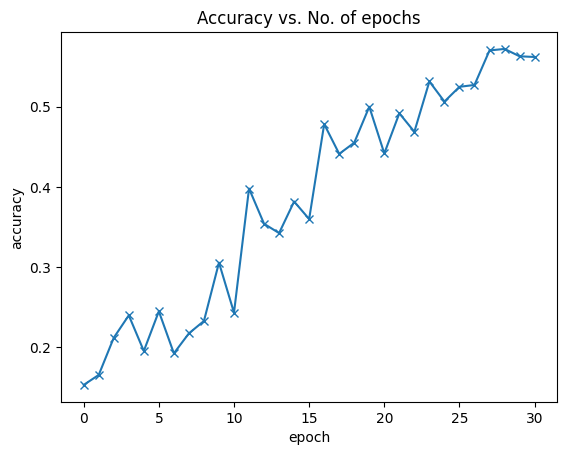

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

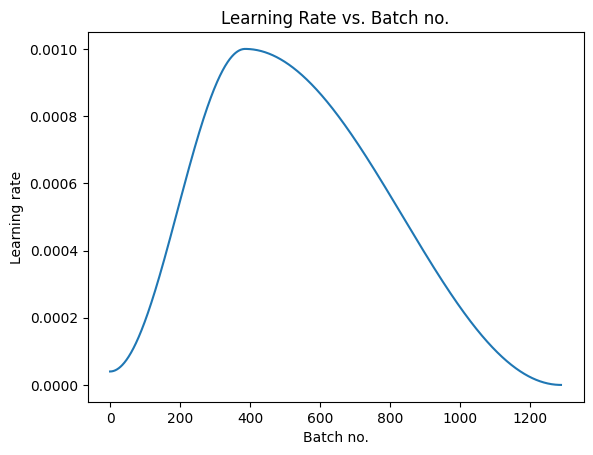

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/deep_learning_project/emotion_detection_model_state.pth')

In [19]:
model = to_device(ResNet(1, len(classes_train)), device)
model.load_state_dict(torch.load('/content/drive/MyDrive/deep_learning_project/emotion_detection_model_state.pth'))
model.eval()

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.2079057693481445, 'val_acc': 0.561882734298706}]

In [24]:
! pip install -q torchview

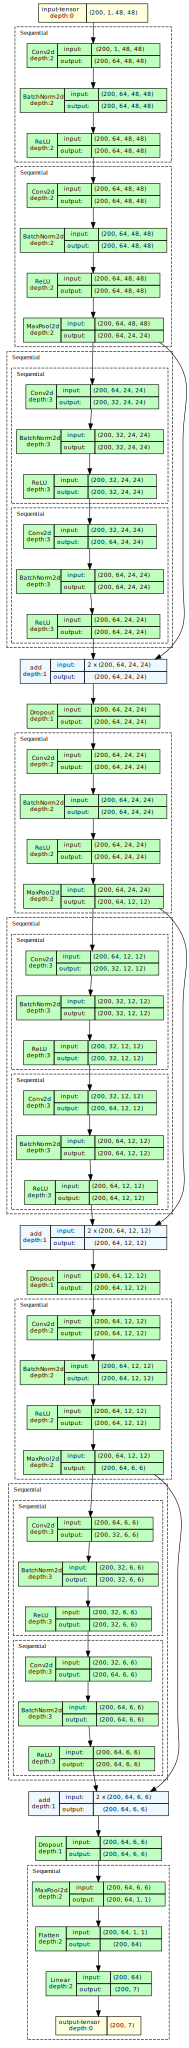

In [30]:
from torchview import draw_graph

model_graph = draw_graph(ResNet(1, len(classes_train)), input_size=(200,1,48,48), expand_nested=True,save_graph=True,filename='model.png',directory='/content/drive/MyDrive/deep_learning_project/')
model_graph.resize_graph(scale=5.0)
model_graph.visual_graph

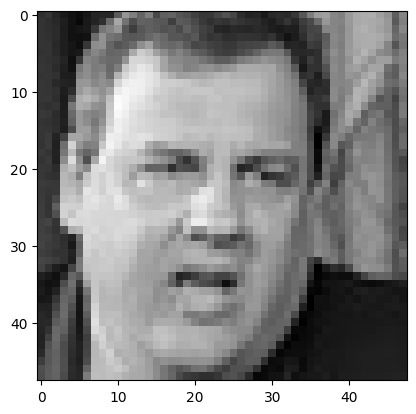

In [31]:
sample_img=cv2.imread("/content/drive/MyDrive/deep_learning_project/face_expression_dataset/train/angry/Training_2944904.jpg")
plt.imshow(sample_img)

In [32]:
gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
gray.shape

(48, 48)

In [51]:
from torchvision import transforms
from PIL import Image

image = Image.open('/content/drive/MyDrive/deep_learning_project/face_expression_dataset/test/surprise/PrivateTest_10072988.jpg')
image = valid_tfms(image)
image = image.to(device)
output = model(image.unsqueeze(0))
print(output)
maxindex = output.cpu().data.numpy().argmax()
#maxindex = int(np.argmax(output))
label = emotion_dict[maxindex]
print(label)

tensor([[16.9839, 14.0454, 18.6207, 15.0102, 14.1571, 14.8989, 20.0590]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Surprised


In [ ]:
cap = cv2.VideoCapture(0)
face_classifier = cv2.CascadeClassifier("/content/drive/MyDrive/deep_learning_project/haarcascade_frontalface_default.xml")
while True:
  try:
    # Grab a single frame of video
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720))
    labels = []
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi_gray = gray[y : y + h, x : x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray]) != 0:
            roi = tt.functional.to_pil_image(roi_gray)
            roi = tt.functional.to_grayscale(roi)
            roi = tt.ToTensor()(roi).unsqueeze(0)

            # make a prediction on the ROI
            tensor = model(roi)
            pred = torch.max(tensor, dim=1)[1].tolist()
            label = class_labels[pred[0]]

            label_position = (x, y)
            cv2.putText(
                frame,
                label,
                label_position,
                cv2.FONT_HERSHEY_COMPLEX,
                2,
                (0, 255, 0),
                3,
            )
        else:
            cv2.putText(
                frame,
                "No Face Found",
                (20, 60),
                cv2.FONT_HERSHEY_COMPLEX,
                2,
                (0, 255, 0),
                3,
            )

    cv2.imshow("Emotion Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
  except:
    break

cap.release()
cv2.destroyAllWindows()